# Readers

> Defines a Pandas accessor and several methods for analyzing, plotting, and exporting wereable data.

In [ ]:
#| default_exp readers

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *

In [ ]:
#| export
import json
import numpy as np
import pandas as pd
from typing import Dict

#| hide
# Pandas Accessor

In [ ]:
#| export
#| hide
VALID_WEREABLE_STREAMS = ['steps', 'heartrate', 'wake', 'light_estimate', 'activity']

In [ ]:
#| export
#| hide
@pd.api.extensions.register_dataframe_accessor("wereable")
class WereableAccessor:
    "pd.DataFrame accessor implementing wereable-specific methods"
    def __init__(self, pandas_obj):
        self._validate_columns(pandas_obj)
        self._obj = pandas_obj

    @staticmethod
    def _validate_columns(obj):
        if 'datetime' not in obj.columns:
            raise AttributeError("DataFrame must have 'datetime' column.")

        if not any([col in obj.columns for col in VALID_WEREABLE_STREAMS]):
            raise AttributeError(f"DataFrame must have at least one wereable data column from: {VALID_WEREABLE_STREAMS}.")
        
    @staticmethod
    def _validate_metadata(metadata):
        if not isinstance(metadata, dict):
            raise AttributeError("Metadata must be a dictionary.")
        if not any([key in metadata.keys() for key in ['data_id', 'subject_id']]):
            raise AttributeError("Metadata must have at least one of the following keys: data_id, subject_id.")
        if not all([isinstance(value, str) for value in metadata.values()]):
            raise AttributeError("Metadata values must be strings.")
    
    def is_valid(self):
        self._validate_columns(self._obj)
        self._validate_metadata(self._obj.attrs)
        return True

    def add_metadata(self,
                     metadata: Dict[str, str], # metadata containing data_id, subject_id, or other_info
                     inplace: bool = False, # whether to return a new dataframe or modify the current one
                     ):
        self._validate_metadata(metadata)
        if inplace:
            for key, value in metadata.items():
                self._obj.attrs[key] = value
        else:
            obj = self._obj.copy()
            for key, value in metadata.items():
                obj.attrs[key] = value
            return obj


    def plot(self, 
             name: str, # name of the wereable data to plot (one of steps, heartrate, wake, light_estimate, or activity)
             ax=None, # matplotlib axes
             *args, # arguments to pass to matplotlib.pyplot.plot
             **kwargs # keyword arguments to pass to matplotlib.pyplot.plot
             ):
        if name not in VALID_WEREABLE_STREAMS:
            raise AttributeError(f"Name must be one of: {VALID_WEREABLE_STREAMS}.")
        if ax is None:
            ax = self._obj.plot(x='datetime', y=name, *args, **kwargs)
        else:
            ax = self._obj.plot(x='datetime', y=name, ax=ax, *args, **kwargs)
        return ax

C:\Users\tavel\AppData\Local\Temp\ipykernel_18132\3254243483.py:4: UserWarning: registration of accessor <class '__main__.WereableAccessor'> under name 'wereable' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class WereableAccessor:


In [ ]:
#| hide
# test wereable accessor's column validation
df_only_datetime = pd.DataFrame({'datetime': pd.date_range('2020-01-01', periods=10)})
test_fail(lambda: df_only_datetime.wereable.add_metadata({'data_id': 'test'}),
          contains="DataFrame must have at least one wereable data column from: ['steps',")
df_only_wereable = pd.DataFrame({'steps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
test_fail(lambda: df_only_wereable.wereable.add_metadata({'data_id': 'test'}),
          contains="DataFrame must have 'datetime' column.")

In [ ]:
#| hide
# test wereable accessor's metadata addition
df = pd.DataFrame({'datetime': pd.date_range('2020-01-01', '2020-01-02', periods=10),
                   'steps': [0, 10, 0, 0, 0, 0, 20, 28, 0, 0],
                   'heartrate': [120, 90, 100, 80, 120, 100, 140, 130, 120, 110]})
df.wereable.add_metadata({'data_id': 'test', 'subject_id': 'test'}, inplace=True)
test_eq(df.attrs['data_id'], 'test')
test_eq(df.attrs['subject_id'], 'test')

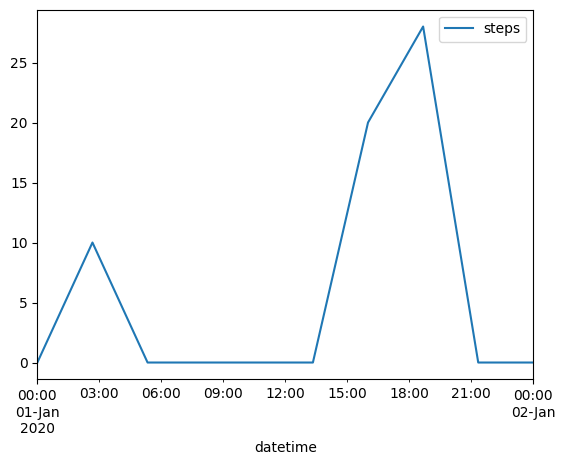

In [ ]:
#| hide
# test wereable accessor's plotting
df = pd.DataFrame({'datetime': pd.date_range('2020-01-01', '2020-01-02', periods=10),
                   'steps': [0, 10, 0, 0, 0, 0, 20, 28, 0, 0],
                   'heartrate': [120, 90, 100, 80, 120, 100, 140, 130, 120, 110]})
ax = df.wereable.plot('steps')
test_eq(ax.get_xlabel(), 'datetime')

#| hide
# Load files

In [ ]:
#| export
#| hide
def load_json(filepath: str, # path to file
              metadata: Dict[str, str] = None, # metadata containing data_id, subject_id, or other_info
              ) -> Dict[str, pd.DataFrame]: # dictionary of wereable dataframes, one key:value pair per wereable data stream
    "Create a dataframe from a json containing a single or multiple streams of wereable data"
    # validate inputs
    if not isinstance(filepath, str):
        raise AttributeError("Filepath must be a string.")
    if metadata is not None:
        WereableAccessor._validate_metadata(metadata)
    # load json
    jdict = json.load(open(filepath, 'r'))
    # check that keys are valid
    for key in jdict.keys():
        if key not in VALID_WEREABLE_STREAMS:
            raise AttributeError("Invalid key in JSON file. Keys must be one of steps, heartrate, wake, light_estimate, or activity.")
    # create a df for each wereable stream
    df_dict = {key: pd.DataFrame.from_dict(jdict[key]) for key in jdict.keys()}
    for key in df_dict.keys():
        df = df_dict[key]
        # create datetime column
        if key == 'heartrate':
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
        else:
            df['start'] = pd.to_datetime(df['start'], unit='s')
            df['end'] = pd.to_datetime(df['end'], unit='s')
            df['datetime'] = df['start']
        # add metadata to each df
        if metadata is not None:
            df.wereable.add_metadata(metadata, inplace=True)
        else:
            df.wereable.add_metadata({'data_id': 'unknown', 'subject_id': 'unknown'}, inplace=True)
        df_dict[key] = df
    return df_dict

In [ ]:
#| hide
# test loading a json
data_path = '../../circadian/sample_data/sample_data.json'
df_dict = load_json(data_path)
df_dict = load_json(data_path, metadata={'data_id': 'sample_data', 'subject_id': 'sample_subject'})

In [ ]:
#| export
#| hide
def load_csv(filepath: str, # full path to csv file to be loaded
             metadata: Dict[str, str] = None, # metadata containing data_id, subject_id, or other_info
             timestamp_col: str = None, # name of the column to be used as timestamp. If None, it is assumed that a `datetime` column exists
             *args, # arguments to pass to pd.read_csv
             **kwargs, # keyword arguments to pass to pd.read_csv
             ):
    "Create a dataframe from a csv containing wereable data"
    # validate inputs
    if not isinstance(filepath, str):
        raise AttributeError("Filepath must be a string.")
    if not isinstance(timestamp_col, str) and timestamp_col is not None:
        raise AttributeError("Timestamp column must be a string.")
    if metadata is not None:
        WereableAccessor._validate_metadata(metadata)
    # load csv
    df = pd.read_csv(filepath, *args, **kwargs)
    # create datetime column
    if timestamp_col is not None:
        df['datetime'] = pd.to_datetime(df[timestamp_col], unit='s')
    if timestamp_col is None and 'datetime' not in df.columns:
        raise AttributeError("CSV file must have a column named 'datetime' or a timestamp column must be provided.")
    # add metadata
    if metadata is not None:
        df.wereable.add_metadata(metadata, inplace=True)
    else:
        df.wereable.add_metadata({'data_id': 'unknown', 'subject_id': 'unknown'}, inplace=True)
    return df

In [ ]:
#| hide
# test loading a csv
data_path = '../../circadian/sample_data/sample_data.csv'
df = load_csv(data_path, timestamp_col='timestamp')
df = load_csv(data_path, 
              metadata={'data_id': 'sample_data', 'subject_id': 'sample_subject'},
              timestamp_col='timestamp')
# test loading a csv with no datetime column
test_fail(lambda: load_csv(data_path), 
          contains="CSV file must have a column named 'datetime' or a timestamp column must be provided.")
test_fail(lambda: load_csv(data_path, metadata={'data_id': '1', 'subject_id': 'sample_subject'}),
          contains="CSV file must have a column named 'datetime' or a timestamp column must be provided.")
# test input validation
test_fail(lambda: load_csv(1),
          contains="Filepath must be a string.")
test_fail(lambda: load_csv(data_path, timestamp_col=1),
          contains="Timestamp column must be a string.")
test_fail(lambda: load_csv(data_path, metadata=1),
          contains="Metadata must be a dictionary.")

In [ ]:
ACTIWATCH_COLUMN_RENAMING = {
    'White Light': 'light_estimate',
    'Sleep/Wake': 'wake',
    'Activity': 'activity',
} 

In [ ]:
#| export
#| hide
def load_actiwatch(filepath: str, # full path to csv file to be loaded
                   metadata: Dict[str, str] = None, # metadata containing data_id, subject_id, or other_info
                   *args, # arguments to pass to pd.read_csv
                   **kwargs, # keyword arguments to pass to pd.read_csv
                   ) -> pd.DataFrame: # dataframe with the wereable data
    "Create a dataframe from an actiwatch csv file"
    # validate inputs
    if not isinstance(filepath, str):
        raise AttributeError("Filepath must be a string.")
    if metadata is not None:
        WereableAccessor._validate_metadata(metadata)
    # load csv
    df = pd.read_csv(filepath, *args, **kwargs)
    df['datetime'] = pd.to_datetime(df['Date']+" "+df['Time'])
    # drop unnecessary columns
    df.drop(columns=['Date', 'Time'], inplace=True)
    # rename columns
    df.rename(columns=ACTIWATCH_COLUMN_RENAMING, inplace=True)
    # add metadata
    if metadata is not None:
        df.wereable.add_metadata(metadata, inplace=True)
    else:
        df.wereable.add_metadata({'data_id': 'unknown', 'subject_id': 'unknown'}, inplace=True)
    return df

In [ ]:
#| hide
# test loading an actiwatch csv
data_path = '../../circadian/sample_data/sample_actiwatch.csv'
df = load_actiwatch(data_path)

,activity,light_estimate,wake,datetime
0,91.0,318.16,1.0,2019-02-20 12:32:00
1,125.0,285.38,1.0,2019-02-20 12:32:30
2,154.0,312.05,1.0,2019-02-20 12:33:00
3,424.0,294.61,1.0,2019-02-20 12:33:30
4,385.0,285.06,1.0,2019-02-20 12:34:00
...,...,...,...,...
55646,0.0,5.02,0.0,2019-03-11 08:15:00
55647,56.0,4.56,1.0,2019-03-11 08:15:30
55648,30.0,2.85,1.0,2019-03-11 08:16:00
55649,9.0,2.39,0.0,2019-03-11 08:16:30


#| hide
# Resample

In [ ]:
WEREABLE_RESAMPLE_METHOD = {
    'steps': 'sum',
    'wake': 'max',
    'heartrate': 'mean',
    'light_estimate': 'mean',
    'activity': 'mean',
}

WEREABLE_NULL_VALUE_CONVERSION = {
    'steps': {0: np.nan},
    'wake': None,
    'heartrate': {0: np.nan},
    'light_estimate': None,
    'activity': None,
}

In [ ]:
#| export
#| hide
def resample_df(df: pd.DataFrame, # dataframe to be resampled
                freq: str = '1min', # frequency to resample to
                name: str = None, # name of the wereable data to resample (one of steps, heartrate, wake, light_estimate, or activity)
                ) -> pd.DataFrame: # resampled dataframe
    "Resample a wereable dataframe"
    # validate inputs
    if not df.wereable.is_valid():
        raise AttributeError("Dataframe must be a valid wereable dataframe.")
    if not isinstance(df, pd.DataFrame):
        raise AttributeError("Dataframe must be a pandas dataframe.")
    if not isinstance(freq, str):
        raise AttributeError("Frequency must be a string.")
    if name is not None and name not in VALID_WEREABLE_STREAMS:
        raise AttributeError(f"Name must be one of: {VALID_WEREABLE_STREAMS}.")
    if name not in df.columns:
        raise AttributeError(f"Name must be one of: {df.columns}.")
    # resample
    if 'start' in df.columns and 'end' in df.columns:
        intial_datetime = df.start.min()
        final_datetime = df.end.max()
        new_datetime = pd.date_range(intial_datetime, final_datetime, freq=freq)
        new_values = np.zeros(len(new_datetime))
        # ...
        new_df = pd.DataFrame({'datetime': new_datetime, name: new_values})
    else:
        intial_datetime = df.datetime.min()
        final_datetime = df.datetime.max()
        new_datetime = pd.date_range(intial_datetime, final_datetime, freq=freq)
        new_values = np.zeros(len(new_datetime))
        # ...
        new_df = pd.DataFrame({'datetime': new_datetime, name: new_values})
    return new_df

In [ ]:
#| hide 
def interval_to_timepoints(start: pd.Timestamp, # start of interval
                           end: pd.Timestamp, # end of interval
                           value: float, # value to distribute across timestamps
                           timestamps: pd.Series, # series of timestamps to distribute `value` across
                           ):
    "Distribute `value` across `timestamps` between `start` and `end`. If no timestamp is contained in the interval, the closest timestamp is selected."
    # select timestamps between start and end
    mask = (timestamps >= start) & (timestamps <= end)
    times = timestamps[mask]
    if len(times) > 0:
        # distribute value across timestamps
        final_values = np.ones(len(times)) * value / len(times)
    else:
        # get closest timestamp and assign value to it
        midpoint = start + (end -  start) / 2
        times = timestamps.iloc[(timestamps - midpoint).abs().argsort()[:1]]
        final_values = np.array([value])
    # create dataframe
    df = pd.DataFrame({'datetime': times, 'value': final_values})
    return df

# test interval_to_timepoints
start = pd.Timestamp('2020-01-03 20:20:10')
end = pd.Timestamp('2020-01-03 20:20:20')
value = 10
timestamps = pd.date_range(pd.Timestamp('2020-01-01 00:00:00'), 
                           pd.Timestamp('2020-01-05 00:00:00'), 
                           freq='1H')
# make series out of timestamps
timestamps = pd.Series(timestamps)
df = interval_to_timepoints(start, end, value, timestamps)
print(df)



Series([], dtype: datetime64[ns])
2020-01-03 20:20:15
68
2020-01-03 00:00:00
68   2020-01-03 20:00:00
dtype: datetime64[ns]
              datetime  value
68 2020-01-03 20:00:00     10


In [ ]:
#| hide
def resample(df, column_names, resample_freq):
    start_datetime = df['start'].min()
    end_datetime = df['end'].max()
    new_datetime = pd.date_range(start_datetime, end_datetime, freq=resample_freq)
    df_dict = {'datetime': new_datetime}
    for col in column_names:
        df_dict[col] = np.nan
    new_df = pd.DataFrame(df_dict)
    return new_df

# test
df = pd.DataFrame({
    'start': pd.date_range('2020-01-01', periods=10, freq='1H'),
    'end': pd.date_range('2020-01-01', periods=10, freq='1H') + pd.Timedelta('1H'),
    'steps': [1, 10, 5, 6, 0, 0, 20, 28, 0, 0],
})
new_df = resample(df, ['steps'], '30T')
print(new_df)


              datetime  steps
0  2020-01-01 00:00:00    NaN
1  2020-01-01 00:30:00    NaN
2  2020-01-01 01:00:00    NaN
3  2020-01-01 01:30:00    NaN
4  2020-01-01 02:00:00    NaN
5  2020-01-01 02:30:00    NaN
6  2020-01-01 03:00:00    NaN
7  2020-01-01 03:30:00    NaN
8  2020-01-01 04:00:00    NaN
9  2020-01-01 04:30:00    NaN
10 2020-01-01 05:00:00    NaN
11 2020-01-01 05:30:00    NaN
12 2020-01-01 06:00:00    NaN
13 2020-01-01 06:30:00    NaN
14 2020-01-01 07:00:00    NaN
15 2020-01-01 07:30:00    NaN
16 2020-01-01 08:00:00    NaN
17 2020-01-01 08:30:00    NaN
18 2020-01-01 09:00:00    NaN
19 2020-01-01 09:30:00    NaN
20 2020-01-01 10:00:00    NaN


In [ ]:
#| hide
def resample_dataframe(df, column_names, resample_freq, inplace=False):
    if isinstance(column_names, str):
        column_names = [column_names]
    elif not isinstance(column_names, list):
        raise AttributeError("Column names must be a string or a list of strings.")

    df_start = df['datetime'].min()
    df_end = df['datetime'].max()
    new_datetime = pd.date_range(df_start, df_end, freq=resample_freq)
    df_dict = {'datetime': new_datetime}
    for col in column_names:
        df_dict[col] = col
    new_df = pd.DataFrame(df_dict)

    for i in range(len(new_df)):
        start = new_df['datetime'].iloc[i]
        end = start + pd.to_timedelta(resample_freq)
        mask = (df['datetime'] >= start) & (df['datetime'] < end)
        for col in column_names:
            values = df.loc[mask, col]
            if len(values) == 0:
                new_df[col].iloc[i] = np.nan
            else:
                new_df[col].iloc[i] = values.aggregate(WEREABLE_RESAMPLE_METHOD[col])

    if inplace:
        df = new_df
    else:
        return new_df

In [ ]:
#| export
#| hide
def distribute_stream_over_duration(start: pd.Timestamp, # start of the stream
                                    end: pd.Timestamp, # end of the stream
                                    value: float, # value of the stream
                                    name: str, # name of the stream
                                    resample_freq: str, # frequency to resample the stream to
                                    ) -> pd.DataFrame: # dataframe with the distributed stream
    "Distribute a wereable datapoint over its duration"
    # validate inputs
    if not isinstance(start, pd.Timestamp):
        raise AttributeError("Start must be a pandas Timestamp.")
    if not isinstance(end, pd.Timestamp):
        raise AttributeError("End must be a pandas Timestamp.")
    if not isinstance(value, (int, float)):
        raise AttributeError("Value must be an integer or float.")
    if not isinstance(resample_freq, str):
        raise AttributeError("Resample frequency must be a string.")
    # create dataframe
    if pd.to_timedelta(resample_freq) > (end - start):
        datetime = pd.to_datetime(start + (end - start) / 2, unit='s')
        df = pd.DataFrame({'datetime': datetime, name: value}, index=[0])
    else:
        df = pd.DataFrame({'datetime': pd.date_range(start, end, freq=resample_freq)})
        df[name] = value / len(df)
    return df

In [ ]:
#| hide
# test distributing a stream over a duration
start = pd.Timestamp('2020-01-01 00:00:10')
end = pd.Timestamp('2020-01-01 00:00:20')
value = 1
name = 'value'
resample_freq = '1s'
df = distribute_stream_over_duration(start, end, value, name, resample_freq)
test_eq(df['value'].sum(), value)
test_eq(df['datetime'].iloc[0], start)
test_eq(df['datetime'].iloc[-1], end)
test_eq(len(df), 11)
# test stream with duration shorter than resample frequency
resample_freq = '1min'
df = distribute_stream_over_duration(start, end, value, name, resample_freq)
test_eq(df['value'].sum(), value)
new_datetime = pd.to_datetime(start + (end - start) / 2)
test_eq(df['datetime'].iloc[0], new_datetime)
test_eq(df['datetime'].iloc[-1], new_datetime)
test_eq(len(df), 1)
# test larger file
data_path = '../../circadian/sample_data/sample_data.json'
df_dict = load_json(data_path)
steps = df_dict['steps']
name = 'steps'
resample_freq = '15S'
distributed_df = pd.DataFrame(columns=['datetime', name])
distribute_fn = lambda x: distribute_stream_over_duration(x.start, x.end, x[name], name, resample_freq)
s = steps.loc[steps.datetime < '1970-01-01 00:55:00']
result = pd.concat(s.apply(distribute_fn, axis=1).tolist())
result = result.groupby(result['datetime']).aggregate('sum')
result = result.reset_index(drop=False)
true_dates = pd.concat([pd.date_range('1970-01-01 00:00:00', '1970-01-01 00:01:00', freq=resample_freq).to_series(),
                        pd.date_range('1970-01-01 00:49:00', '1970-01-01 00:51:00', freq=resample_freq).to_series()])
true_dates.reset_index(drop=True, inplace=True)
true_steps_rounded = pd.Series([4.2, 4.2, 4.2, 4.2, 4.2, 1.6, 1.6, 1.6, 1.6, 5.6, 4.0, 4.0, 4.0, 4.0])
test_eq(result['datetime'], true_dates)
test_eq(result['steps'].round(1), true_steps_rounded)
# test duration smaller than resample frequency
resample_freq = '5T'
result = pd.concat(s.apply(distribute_fn, axis=1).tolist())
result = result.groupby(result['datetime']).aggregate('sum')
result = result.reset_index(drop=False)
true_dates = pd.Series([
    pd.Timestamp('1970-01-01 00:00:30'),
    pd.Timestamp('1970-01-01 00:49:30'),
    pd.Timestamp('1970-01-01 00:50:30'),
])
true_steps_rounded = pd.Series([21.0, 8.2, 19.8])
test_eq(result['datetime'], true_dates)
test_eq(result['steps'].round(1), true_steps_rounded)

In [ ]:
#| export
#| hide
def combine_wereable_dataframes(df_dict: Dict[str, pd.DataFrame], # dictionary of wereable dataframes 
                                metadata: Dict[str, str] = None, # metadata containing for the combined dataframe resample_freq: str = '6T', # resampling frequency (e.g. '6T' for 6 minutes)
                                resample_freq: str = '6T', # resampling frequency (e.g. '6T' for 6 minutes)
                                ) -> pd.DataFrame: # combined wereable dataframe
    "Combine a dictionary of wereable dataframes into a single dataframe with resampling"
    df_list = []
    for name in df_dict.keys():
        df = df_dict[name]
        df.wereable.is_valid()
        if name in ['heartrate', 'light_estimate']:
            resampled_df = df.resample(
                                resample_freq, on='datetime'
                            ).agg(WEREABLE_RESAMPLE_METHOD[name])
            resampled_df.reset_index(inplace=True)
        else:
            # distribute wereable stream between start and end times
            distributed_df = pd.DataFrame(columns=['datetime', name])
            distribute_fn = lambda x: distribute_stream_over_duration(x.start, x.end, x[name], name, resample_freq)
            distributed_df = pd.concat(df.apply(distribute_fn, axis=1).tolist())
            distributed_df = distributed_df.groupby(distributed_df['datetime']).aggregate('sum') # if there are multiple values for the same datetime, add them
            distributed_df = distributed_df.reset_index(drop=False)
            # resample the distributed stream (to clean up those durations that are shorter than the resample frequency)
            resampled_df = distributed_df.resample(
                                resample_freq, on='datetime'
                            ).agg(WEREABLE_RESAMPLE_METHOD[name])
        if WEREABLE_NULL_VALUE_CONVERSION[name] is not None:
            resampled_df.replace(WEREABLE_NULL_VALUE_CONVERSION[name], inplace=True)
        df_list.append(resampled_df)
    # merge all dfs by datetime
    df = df_list[0]
    for i in range(1, len(df_list)):
        df = df.merge(df_list[i], on='datetime', how='outer')
    # sort by datetime
    df.sort_values(by='datetime', inplace=True)
    # add metadata
    if metadata is not None:
        df.wereable.add_metadata(metadata, inplace=True)
    else:
        df.wereable.add_metadata({'data_id': 'combined_dataframe'}, inplace=True)
    return df

In [ ]:
#| hide
# test combining wereable dataframes
# TODO: Current implementation takes 8 min for the whole file, can we improve it?
data_path = '../../circadian/sample_data/sample_data.json'
df_dict = load_json(data_path)
# reduce all dataframes to a tenth their size to avoid slow tests
for key in df_dict.keys():
    df_dict[key] = df_dict[key].iloc[:int(len(df_dict[key]) / 10)]
# combine dataframes
result = combine_wereable_dataframes(df_dict)
# test passing a single dataframe from a csv
data_path = '../../circadian/sample_data/sample_data.csv'
df = load_csv(data_path, timestamp_col='timestamp')
combined_df = combine_wereable_dataframes({'heartrate': df}, resample_freq='24H')

data reduced


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()